# Deep Learning with Sentinel and Urban Morphological Parameters (UMP)

This notebook will focus on the modelling aspect of the project. For engineering of data, refer to sentinel_plateau.ipynb instead

In [1]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

In [2]:
# Import of necessary libraries

import pandas as pd
import numpy as np
import pickle

from shapely import Polygon
from osgeo import gdal

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.sp_utils as sp


In [17]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

## Preparing data for input

Combining both the sentinel images and the corresponding UMPs

### Data Loading

In [4]:
# Load sentinel
sentinel_full = gdal.Open("data/sentinel/Sentinel_fullTokyo_3857.tiff", gdal.GA_ReadOnly)
sentinel_arr = sentinel_full.ReadAsArray()
sentinel_arr.shape

(12, 3122, 3167)

In [5]:
# Load data and see if they are ok
labels_df = pd.read_csv("data/full_Tokyo_plateau/tokyo_ump.csv")
labels_df

,Unnamed: 0,x_coord,y_coord,height_avg_bld,height_avg_area,height_avg_total,height_std,height_max,height_min,height_percentile,planar_area,frontal_area,total_area,planar_index,frontal_index
0,0,15556169,4239090,9.430429,26.206931,9.082073,115846.195627,49.7,2.0,32.244,346552.350035,206219.632285,1000000,0.346552,0.206220
1,1,15556669,4239090,13.051634,34.327736,8.534822,266143.703659,49.7,2.1,44.336,248627.578320,121887.442667,1000000,0.248628,0.121887
2,2,15557169,4239090,15.077551,26.184764,2.226291,80714.236585,49.5,2.9,49.500,85022.387484,40739.998584,1000000,0.085022,0.040740
3,3,15557669,4239090,29.800000,27.479736,0.387221,112338.114797,35.3,26.7,34.984,14091.135819,6606.286989,1000000,0.014091,0.006606
4,4,15558169,4239090,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.000000,1000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,3321,15561169,4272090,8.719214,14.593501,4.354586,15883.773693,90.5,2.0,26.658,298392.165109,269156.872575,1000000,0.298392,0.269157
3322,3322,15561669,4272090,8.244629,12.399513,3.690500,7950.307778,55.9,2.0,22.900,297632.627719,250505.629353,1000000,0.297633,0.250506
3323,3323,15562169,4272090,7.932749,11.311879,3.254257,4714.404151,40.8,2.0,20.992,287684.886491,244455.426714,1000000,0.287685,0.244455
3324,3324,15562669,4272090,7.987299,10.615458,3.196222,4069.347920,40.8,2.0,21.168,301091.326506,240276.673433,1000000,0.301091,0.240277


### Check that data is valid

Ensure that data is valid and within range

In [6]:
# Here we can see that the label fits within the boundary of the sentienl data that we have
sp.getBounds(sentinel_full)

Upper Left Corner: 15538560.0 4273200.858988403
Lower Right Corner: 15573273.32390456 4238980.777766415
Width: 34713.32390456088
Height: 34220.081221988425
Area: 1187892763.4992657
Pixel Width: 10.960948501597723


(15538560.0, 4238980.777766415, 15573273.32390456, 4273200.858988403)

In [7]:
coords = labels_df["x_coord"].min(), labels_df["x_coord"].max(), labels_df["y_coord"].min(), labels_df["y_coord"].max()

print("Upper Left Corner:", coords[0], coords[3])
print("Lower Right Corner:", coords[1], coords[2])
print("Width:", coords[1] - coords[0])
print("Height:", coords[3] - coords[2])
print("Area:", (coords[1] - coords[0])*(coords[3] - coords[2]))

Upper Left Corner: 15538669 4272090
Lower Right Corner: 15572169 4239090
Width: 33500
Height: 33000
Area: 1105500000


### Attempt to crop the necessary section out of the image

Crops and visualises a sample input

In [8]:
boundary = Polygon(sp.generateCorners([15572169, 4239090], return_int= True))
# Define functions to get items
# g = gdal.Warp("", sentinel_full, format="MEM",
#               cropToCutline=True, cutlineLayer=boundary)

g = gdal.Translate('', sentinel_full, projWin = [15538669, 4272090, 15539669, 4271090], format= "MEM")

In [9]:
sp.getBounds(g)

Upper Left Corner: 15538658.648536514 4272093.803189742
Lower Right Corner: 15539656.09485016 4271096.356876097
Width: 997.4463136456907
Height: 997.4463136456907
Area: 994899.1486053775
Pixel Width: 10.960948501597723


(15538658.648536514, 4271096.356876097, 15539656.09485016, 4272093.803189742)

In [10]:
g.ReadAsArray().shape

(12, 91, 91)

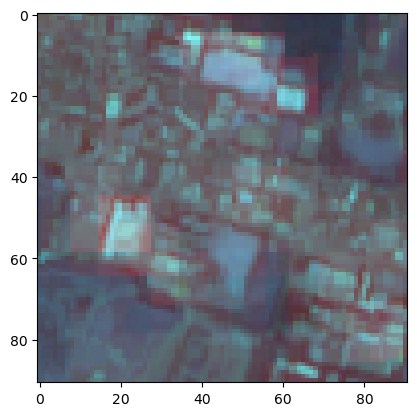

In [11]:
sp.visualiseBands(g, [1, 2, 3])

In [12]:
def getX(coords, data= sentinel_full):
    """
    Returns the input array from a gdal dataset (tif) given a set f coordinates

    # Parameters\n
    - coords: A list of coordinates, x_upper_left, y_upper_left, x_lower_right, y_lower_right

    # Returns\n
    - np array of the specified region 
    """
    g = gdal.Translate('', sentinel_full, projWin = coords, format= "MEM")
    return g.ReadAsArray()

def UlLr(LL_coord, width= 1000):
    """
    Returns the upper left x, y and lower right x, y as a list of 4 elements.

    Utility function in generating the input arrays.
    """
    return [LL_coord[0], LL_coord[1]+width, LL_coord[0]+width, LL_coord[1]]

In [13]:
y_test = getX(UlLr([15538669, 4271090]))
y_test.shape

(12, 91, 91)

In [14]:
torch.tensor(y_test)

tensor([[[ 754.0000,  754.0000,  754.0000,  ...,  408.0000,  560.0000,
           554.0000],
         [ 754.0000,  754.0000,  754.0000,  ...,  408.0000,  560.0000,
           554.0000],
         [ 754.0000,  754.0000,  754.0000,  ...,  408.0000,  560.0000,
           554.0000],
         ...,
         [ 391.5000,  391.5000,  469.0000,  ...,  614.5000,  614.5000,
           502.0000],
         [ 391.5000,  391.5000,  469.5000,  ...,  614.5000,  614.5000,
           502.0000],
         [ 391.5000,  391.5000,  469.5000,  ...,  614.5000,  614.5000,
           502.0000]],

        [[ 645.0000,  645.0000,  633.0000,  ...,  500.0000,  573.0000,
           591.0000],
         [ 680.0000,  680.0000,  624.0000,  ...,  570.0000,  592.0000,
           577.0000],
         [ 725.0000,  725.0000,  608.0000,  ...,  612.0000,  602.0000,
           479.5000],
         ...,
         [ 613.5000,  596.0000,  613.0000,  ...,  414.5000,  354.0000,
           526.0000],
         [ 613.5000,  627.0000,  718.000

In [15]:
g.ReadAsArray().shape

(12, 91, 91)

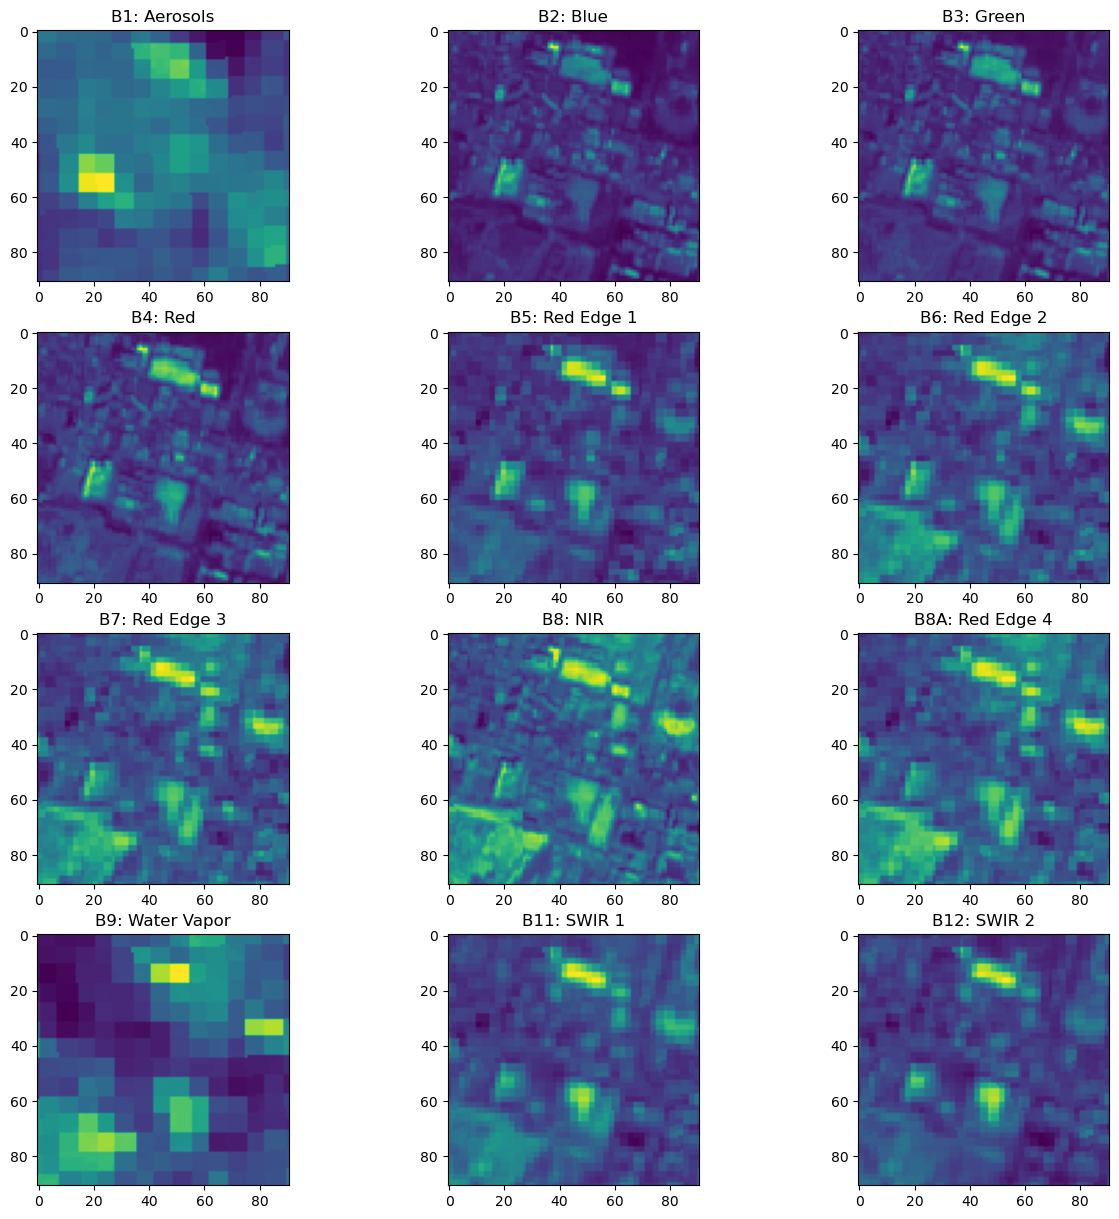

In [16]:
sp.visualiseBands(g)

### Creating the dataset using the above methods

In [24]:
# Create dataset
target_vars = list(labels_df.columns[3:12]) + list(labels_df.columns[13:])
print("What we want to predict:", target_vars)
y = labels_df[target_vars].head()
y

What we want to predict: ['height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std', 'height_max', 'height_min', 'height_percentile', 'planar_area', 'frontal_area', 'planar_index', 'frontal_index']


,height_avg_bld,height_avg_area,height_avg_total,height_std,height_max,height_min,height_percentile,planar_area,frontal_area,planar_index,frontal_index
0,9.430429,26.206931,9.082073,115846.195627,49.7,2.0,32.244,346552.350035,206219.632285,0.346552,0.206220
1,13.051634,34.327736,8.534822,266143.703659,49.7,2.1,44.336,248627.578320,121887.442667,0.248628,0.121887
2,15.077551,26.184764,2.226291,80714.236585,49.5,2.9,49.500,85022.387484,40739.998584,0.085022,0.040740
3,29.800000,27.479736,0.387221,112338.114797,35.3,26.7,34.984,14091.135819,6606.286989,0.014091,0.006606
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000


In [25]:
# Create iterable of (x, y)
x = [getX(UlLr(coords)) for coords in zip(labels_df['x_coord'], labels_df['y_coord'])]
x[:3]

[array([[[ 656. ,  662. ,  662. , ...,  267. ,  267. ,  267. ],
         [ 656. ,  662. ,  662. , ...,  267. ,  267. ,  267. ],
         [ 656. ,  662. ,  662. , ...,  267. ,  267. ,  267. ],
         ...,
         [ 756. ,  756. ,  756. , ...,  657. ,  657. ,  657. ],
         [ 756. ,  756. ,  756. , ...,  657. ,  657. ,  657. ],
         [ 756. ,  756. ,  756. , ...,  657. ,  657. ,  657. ]],
 
        [[ 825.5,  999. ,  783. , ...,  273. ,  271. ,  285. ],
         [ 800. ,  883. ,  764. , ...,  260. ,  270. ,  264. ],
         [ 771. ,  904. ,  694. , ...,  290. ,  280. ,  273. ],
         ...,
         [ 811. ,  703. ,  908. , ...,  660. ,  775.5,  833. ],
         [ 873. ,  727. ,  839. , ...,  817. ,  707. ,  640. ],
         [ 841. ,  716. ,  872. , ...,  799. ,  747.5,  735.5]],
 
        [[ 998. ,  974. ,  850. , ...,  383. ,  348. ,  350. ],
         [ 853.5,  935. ,  802. , ...,  365. ,  353. ,  337. ],
         [ 785. ,  910. ,  772. , ...,  348. ,  333. ,  338. ],
      

In [26]:
x = np.array(x)
x.shape

(3326, 12, 91, 91)

In [27]:
y = [row for row in labels_df[[
        'height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std',
        'height_max', 'height_min', 'height_percentile', 'planar_area',
        'frontal_area', 'total_area', 'planar_index', 'frontal_index']].to_numpy()
    ]
y = np.array(y)
y.shape

(3326, 12)

In [28]:
ds = zip(x, y)
ds = [(i[0].astype("f"), i[1].astype("f")) for i in ds]
with open("./data/tokyo_data.pkl", "wb") as f: 
    pickle.dump(ds, f)


## Load previously saved dataset

Generates a `DataLoaders` object for input into the learner

Note to _not_ use this in production as validation is not properly separated from the training

In [29]:
with open("./data/tokyo_data.pkl", "rb") as f:
    ds = pickle.load(f)
len(ds)

3326

In [31]:
# Converts to float for model compatability (update: already converted in previous stage)
# ds = [(i[0].astype("f"), i[1].astype("f")) for i in ds]
# ds = [(tensor(i[0].astype("f"), requires_grad= True), tensor(i[1].astype("f"))) for i in ds]
type(ds[0][0]), type(ds[0][0][0][0][0])

(numpy.ndarray, numpy.float32)

In [32]:
len(ds), ds[0][0].shape, ds[0][1].shape

(3326, (12, 91, 91), (12,))

In [33]:
ds[0]

(array([[[ 656. ,  662. ,  662. , ...,  267. ,  267. ,  267. ],
         [ 656. ,  662. ,  662. , ...,  267. ,  267. ,  267. ],
         [ 656. ,  662. ,  662. , ...,  267. ,  267. ,  267. ],
         ...,
         [ 756. ,  756. ,  756. , ...,  657. ,  657. ,  657. ],
         [ 756. ,  756. ,  756. , ...,  657. ,  657. ,  657. ],
         [ 756. ,  756. ,  756. , ...,  657. ,  657. ,  657. ]],
 
        [[ 825.5,  999. ,  783. , ...,  273. ,  271. ,  285. ],
         [ 800. ,  883. ,  764. , ...,  260. ,  270. ,  264. ],
         [ 771. ,  904. ,  694. , ...,  290. ,  280. ,  273. ],
         ...,
         [ 811. ,  703. ,  908. , ...,  660. ,  775.5,  833. ],
         [ 873. ,  727. ,  839. , ...,  817. ,  707. ,  640. ],
         [ 841. ,  716. ,  872. , ...,  799. ,  747.5,  735.5]],
 
        [[ 998. ,  974. ,  850. , ...,  383. ,  348. ,  350. ],
         [ 853.5,  935. ,  802. , ...,  365. ,  353. ,  337. ],
         [ 785. ,  910. ,  772. , ...,  348. ,  333. ,  338. ],
      

In [34]:
dls = DataLoaders().from_dsets(ds[:2662], ds[2662:])

In [35]:
# Batchsize = 64 by default
dls.one_batch()[0].shape, dls.one_batch()[1].shape

(torch.Size([64, 12, 91, 91]), torch.Size([64, 12]))

## Testing using simple convolution network

"It works, badly"

In [36]:
def conv(ni, nf, ks= 3, act= True, stride= 2):
    """
    Simple convolution layer with stride 2 to reduce output dimensions
    """
    res = nn.Conv2d(ni, nf, stride= stride, kernel_size= ks, padding= ks//2)
    if act: 
        res = nn.Sequential(res, nn.ReLU())
    return res

In [37]:
def size_cal(n, pad, ks, stride):
    """
    Simple function to calculate the dimensions of output
    """
    r = (n + 2 * pad - ks) // stride + 1
    print(r)
    return r

In [14]:
[48*(2**i) for i in range(7)]

[48, 96, 192, 384, 768, 1536, 3072]

In [126]:
# Simple CNN to ensure things can run
# Input = 91x91
simple_cnn = nn.Sequential(
    conv(12, 48),                #46x46
    conv(48, 96),                #23x23
    conv(96, 192),               #12x12
    conv(192, 384),              #6x6
    conv(384, 768),              #3x3
    conv(768, 1536),             #2x2
    conv(1536, 12),              #1x1
    Flatten(),
)

In [43]:
xa, ya = first(dls.train)
# xa, ya = to_cpu(xa), to_cpu(ya)
xa.shape, ya.shape

(torch.Size([64, 12, 91, 91]), torch.Size([64, 12]))

In [44]:
# Check for correct output shape
simple_cnn(xa).shape

torch.Size([64, 12])

In [45]:
# Check for valid values
simple_cnn(xa)[0]

TensorBase([0.0000, 0.0000, 0.8789, 0.0000, 0.9516, 1.2113, 0.9188, 0.0000,
            0.0000, 0.0000, 0.1565, 0.0000], grad_fn=<AliasBackward0>)

In [46]:
F.mse_loss(simple_cnn(xa), ya)

TensorBase(1.0430e+11, grad_fn=<AliasBackward0>)

In [48]:
# Check loss calculation for all, ensure no NaN or error
count = 0
for i in dls.train:
    xb, yb = i
    # print(F.mse_loss(simple_cnn(xb), yb))
    count += 1
    xNan = torch.isnan(torch.sum(xb))
    yNan = torch.isnan(torch.sum(yb))
    if xNan or yNan:
        print("Count:", count, end= " - ")
        print("xa NaN:", torch.isnan(torch.sum(xb)))
        print("ya NaN:", torch.isnan(torch.sum(yb)))
        print(xb)
        print(yb)
        break

In [121]:
d = [
    'height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std',
    'height_max', 'height_min', 'height_percentile', 'planar_area',
    'frontal_area', 'total_area', 'planar_index', 'frontal_index']
def RMSELoss(preds, targets, idx):
    r = (preds - targets).transpose(1, 0)
    # print(r)
    r = torch.sqrt(torch.mean(r[idx]**2))
    # print(r)
    return r

height_avg_bld = partial(RMSELoss, idx= 0)
height_avg_area = partial(RMSELoss, idx= 1)
height_avg_total = partial(RMSELoss, idx= 2)
height_std = partial(RMSELoss, idx= 3)
height_max = partial(RMSELoss, idx= 4)
height_min = partial(RMSELoss, idx= 5)
height_percentile = partial(RMSELoss, idx= 6)
planar_area = partial(RMSELoss, idx= 7)
frontal_area = partial(RMSELoss, idx= 8)
total_area = partial(RMSELoss, idx= 9)
planar_index = partial(RMSELoss, idx= 10)
frontal_index = partial(RMSELoss, idx= 11)
height_avg_bld = partial(RMSELoss, idx= 0)


In [83]:
(simple_cnn(xa) - ya).shape, (simple_cnn(xa) - ya).transpose(1, 0).shape

(torch.Size([64, 12]), torch.Size([12, 64]))

In [93]:
# RMSELoss(simple_cnn(xa), ya, 0)

{'height_avg_bld': TensorBase(12.4383, grad_fn=<AliasBackward0>)}

In [127]:
learn = Learner(dls, simple_cnn, loss_func=F.mse_loss, metrics= [
    height_avg_bld,
    height_avg_area,
    height_avg_total,
    height_std,
    height_max,
    height_min,
    height_percentile,
    planar_area,
    frontal_area,
    total_area,
    planar_index,
    frontal_index,
])

In [123]:
learn.summary()

Sequential (Input shape: 64 x 12 x 91 x 91)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 48 x 46 x 46   
Conv2d                                    5232       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 96 x 23 x 23   
Conv2d                                    41568      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 192 x 12 x 12  
Conv2d                                    166080     True      
ReLU                                                           
____________________________________________________________________________
                     64 x 384 x 6 x 6    
Conv2d                                    663936     True      
ReLU                                         

In [128]:
learn.validate()

(#13) [97811513344.0,7.48948335647583,11.786456108093262,3.7736122608184814,14698.998046875,53.63890075683594,1.3027247190475464,20.58159828186035,307759.71875,276184.59375...]

SuggestedLRs(valley=0.0002290867705596611)

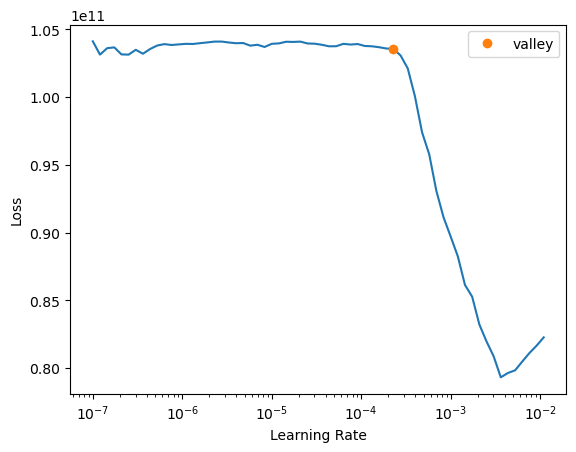

In [129]:
learn.lr_find()

In [132]:
learn.fit_one_cycle(10, 0.0005)
# learn.fit(1, 0.01)

epoch,train_loss,valid_loss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,RMSELoss,time
0,8038388736.000000,2558759936.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,93218.015625,118238.539062,69244.070312,0.307760,0.276185,00:16
1,7544396288.000000,6890519552.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,117798.640625,149263.843750,202800.671875,0.307760,0.276185,00:15
2,6953386496.000000,3772600320.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,93718.304688,128538.117188,124139.242188,0.307760,0.276185,00:15
3,6531956736.000000,3480333056.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,95533.281250,113668.265625,124429.617188,0.307760,0.276185,00:16
4,5979576320.000000,1911911680.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,75529.210938,95497.265625,75486.726562,0.307760,0.276185,00:15
5,5669576192.000000,1851662976.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,72541.335938,93984.492188,74362.914062,0.307760,0.276185,00:16
6,5148158976.000000,2288872448.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,76500.664062,108408.625000,80635.585938,0.307760,0.276185,00:15
7,4898843648.000000,1902244352.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,67864.085938,96328.687500,78949.304688,0.307760,0.276185,00:16
8,4589318656.000000,1963073280.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,69552.820312,96970.648438,80166.015625,0.307760,0.276185,00:16
9,4455900160.000000,2130136960.000000,8.464666,12.575871,3.787554,14699.008789,53.670071,2.063621,20.701805,69065.812500,106714.937500,79618.906250,0.307760,0.276185,00:15


In [137]:
print(*d)

height_avg_bld height_avg_area height_avg_total height_std height_max height_min height_percentile planar_area frontal_area total_area planar_index frontal_index


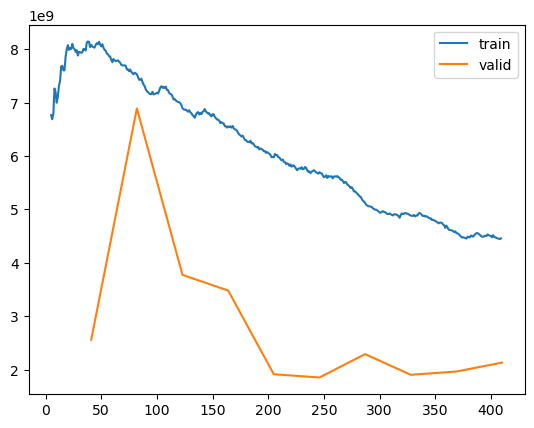

In [133]:
learn.recorder.plot_loss()

## Using architecture from literature review